In [6]:
# Data wrangling
import numpy as np
import pandas as pd  # Not a requirement of giotto-tda, but is compatible with the gtda.mapper module

# Data viz
from gtda.plotting import plot_point_cloud

# TDA magic
from gtda.mapper import (
    CubicalCover,
    make_mapper_pipeline,
    Projection,
    plot_static_mapper_graph,
    plot_interactive_mapper_graph,
    MapperInteractivePlotter
)

# ML tools
from sklearn import datasets
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import random

In [ ]:
pip install giotto-tda


In [7]:
# mds_coords = pd.read_csv("mds_coords_k3.csv").values 
distance_matrix = pd.read_csv("/Users/lu/Desktop/Projects/RStan_prosodic/data/distance_matrix.csv").values
pdf_matrix = pd.read_csv("/Users/lu/Desktop/Projects/RStan_prosodic/data/pdf_matrix.csv").values

In [43]:
# Issues:
# mds doesn't have .transform function
# if no fit_transform, then .fit.transform()

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.manifold import MDS

class WrappedMDS(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=5, normalized_stress='auto', random_state = None):
        self.n_components = n_components
        self.normalized_stress = normalized_stress
        self.mds = MDS(n_components=n_components, 
                       #dissimilarity='euclidean', 
                       normalized_stress=normalized_stress,
                       random_state = random_state)
        self.random_state = random_state

    def fit(self, X, y=None):
        print("1")
        self.mds.fit(X)
        return self

    def transform(self, X):
        print("2")
        return self.mds.fit_transform(X)
    
    def fit_transform(self, X, y=None):
        print("3")
        return self.mds.fit_transform(X)


filter_func = WrappedMDS(n_components=5, random_state=613)


In [ ]:
## testing which part of PCA
#from sklearn.base import BaseEstimator, TransformerMixin
#from sklearn.decomposition import PCA

#class WrappedPCA(BaseEstimator, TransformerMixin):
    #def __init__(self, n_components=2):
        #self.n_components = n_components
        #self.pca = PCA(n_components=n_components)

    #def fit(self, X, y=None):
        #self.pca.fit(X)
        #print("1")
        #return self

    #def transform(self, X):
        #print("2")
        #return self.pca.transform(X)

    #def fit_transform(self, X, y=None):
        #print("3")
        #return self.pca.fit_transform(X)
#filter_func = WrappedPCA(n_components=5)

In [ ]:
mds_coords_first_two = mds_coords[:, :2]

In [46]:
#filter_func = Projection(columns=[0, 1, 2]) # input original data, dimension reduction, PCA or any
#filter_func = MDS(n_components=5)

# Define cover
cover = CubicalCover(n_intervals=4, overlap_frac=0.3)
# Choose clustering algorithm – default is DBSCAN
clusterer = DBSCAN(metric = "precomputed").fit(distance_matrix)


# Configure parallelism of clustering step
n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer, # distance matrix is calculated here. 
    verbose=False,
    n_jobs=n_jobs,
)

#mds, euclidean for the dbscan
#set the filter as umap

In [ ]:
np.random.seed(3047)
fig = plot_static_mapper_graph(pipe, distance_matrix)
fig.show(config={'scrollZoom': True})

In [ ]:
mapper_graph = pipe.fit_transform(distance_matrix)
column_names = distance_matrix_raw.columns.tolist()
node_elements = mapper_graph.vs["node_elements"]

for node_id, indices in enumerate(node_elements):
    words = [column_names[i] for i in indices]
    print(f"Node {node_id}:")
    #print(f"  Indices: {indices}")
    print(f"Words: {words}")


In [ ]:

mapper_graph = pipe.fit_transform(mds_coords)  # Create the mapper graph
print(type(mapper_graph))

print(mapper_graph.vs.attributes())

# Find which points belong to first node of graph
#node_id = 1
node_elements = mapper_graph.vs["node_elements"]
#print(f"Node ID: {node_id}, Node elements: {node_elements[node_id]}, Data points: {mds_coords[node_elements[node_id]]}")


In [ ]:
distance_matrix_raw = pd.read_csv("distance_matrix.csv")

In [ ]:
import json
import numpy as np

np.random.seed(3047)

mapper_graph = pipe.fit_transform(distance_matrix)
adjacency_matrix = np.array(mapper_graph.get_adjacency()).tolist()
node_elements = [list(map(int, ne)) for ne in mapper_graph.vs["node_elements"]]

mapper_result_export = {
    "adjacency": adjacency_matrix,
    "points_in_vertex": node_elements
}

to_remove = set()
n = len(node_elements)

for i in range(n):
    for j in range(n):
        if i != j:
            set_i = set(node_elements[i])
            set_j = set(node_elements[j])
            if set_i < set_j:  # proper subset
                to_remove.add(i)
                break  # i is a proper subset of j

# Step 2: Sort indices descending to delete safely
to_remove = sorted(to_remove, reverse=True)

# Step 3: Remove from points_in_vertex and adjacency
for idx in to_remove:
    del node_elements[idx]
    del adjacency_matrix[idx]
    for row in adjacency_matrix:
        del row[idx]

# Step 4: Update the export dictionary
mapper_result_export = {
    "adjacency": adjacency_matrix,
    "points_in_vertex": node_elements
}



column_names = distance_matrix_raw.columns.tolist()
# Use cleaned node_elements from mapper_result_export
cleaned_node_elements = mapper_result_export["points_in_vertex"]

for node_id, indices in enumerate(cleaned_node_elements):
    words = [column_names[i] for i in indices]
    print(f"Node {node_id}:")
    print(f"  Words: {words}")

with open("mapper_result.json", "w") as f:
    json.dump(mapper_result_export, f)


In [ ]:
import json
import numpy as np

np.random.seed(4)

mapper_graph = pipe.fit_transform(distance_matrix)
adjacency_matrix = np.array(mapper_graph.get_adjacency()).tolist()
node_elements = [list(map(int, ne)) for ne in mapper_graph.vs["node_elements"]]

mapper_result_export = {
    "adjacency": adjacency_matrix,
    "points_in_vertex": node_elements
}

to_remove = set()
n = len(node_elements)

for i in range(n):
    for j in range(n):
        if i != j:
            set_i = set(node_elements[i])
            set_j = set(node_elements[j])
            if set_i < set_j:  # proper subset
                to_remove.add(i)
                break  # i is a proper subset of j

# Step 2: Sort indices descending to delete safely
to_remove = sorted(to_remove, reverse=True)

# Step 3: Remove from points_in_vertex and adjacency
for idx in to_remove:
    del node_elements[idx]
    del adjacency_matrix[idx]
    for row in adjacency_matrix:
        del row[idx]

# Step 4: Update the export dictionary
mapper_result_export = {
    "adjacency": adjacency_matrix,
    "points_in_vertex": node_elements
}



column_names = distance_matrix_raw.columns.tolist()
# Use cleaned node_elements from mapper_result_export
cleaned_node_elements = mapper_result_export["points_in_vertex"]

for node_id, indices in enumerate(cleaned_node_elements):
    words = [column_names[i] for i in indices]
    print(f"Node {node_id}:")
    print(f"  Words: {words}")

with open("mapper_result.json", "w") as f:
    json.dump(mapper_result_export, f)


In [ ]:

points_in_vertex = data["points_in_vertex"]
adjacency = data["adjacency"]

# Step 1: Identify proper subsets
to_remove = set()
n = len(points_in_vertex)

for i in range(n):
    for j in range(n):
        if i != j:
            set_i = set(points_in_vertex[i])
            set_j = set(points_in_vertex[j])
            if set_i < set_j:  # proper subset
                to_remove.add(i)
                break  # No need to check further once i is known to be a subset

# Step 2: Sort indices in descending order so we can safely delete
to_remove = sorted(to_remove, reverse=True)

# Step 3: Remove entries from both `points_in_vertex` and `adjacency`
for idx in to_remove:
    del points_in_vertex[idx]
    del adjacency[idx]
    for row in adjacency:
        del row[idx]

# (Optional) Save the cleaned version
data["points_in_vertex"] = points_in_vertex
data["adjacency"] = adjacency

with open("cleaned_mapper_result.json", "w") as f:
    json.dump(data, f)

## MDS Visualization

In [21]:
import pandas as pd
import numpy as np
from sklearn.manifold import MDS
import plotly.express as px

In [14]:
distance_matrix_raw = pd.read_csv("/Users/lu/Desktop/Projects/RStan_prosodic/data/distance_matrix.csv")
distance_matrix = distance_matrix_raw.values
labels = distance_matrix_raw.columns.tolist()

In [27]:
mds = MDS(n_components=3, random_state=45)
mds_coords = mds.fit_transform(distance_matrix)

/Users/lu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_mds.py:601: UserWarning:

The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.

/Users/lu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



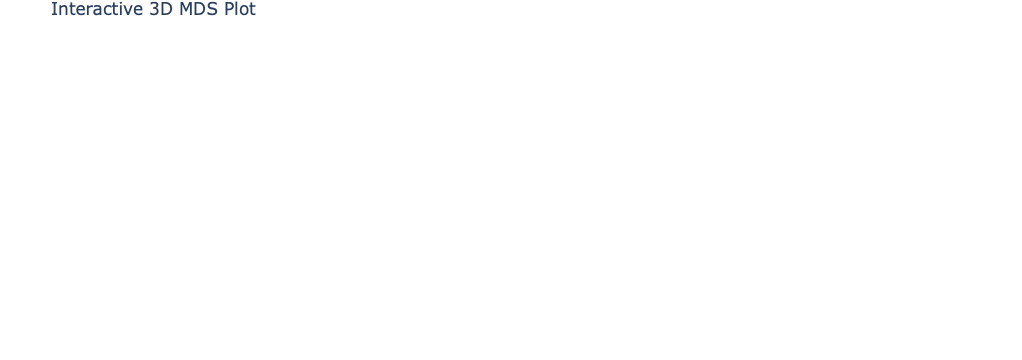

In [28]:
mds_df = pd.DataFrame(mds_coords, columns=["Dim1", "Dim2", "Dim3"])
mds_df["Label"] = labels

 
fig = px.scatter_3d(
    mds_df, x="Dim1", y="Dim2", z="Dim3",
    text="Label",  # adds hover labels
    hover_name="Label",
    title="Interactive 3D MDS Plot",
    opacity=0.8
)

fig.update_traces(marker=dict(size=6, line=dict(width=1, color='black')))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30))
fig.show()

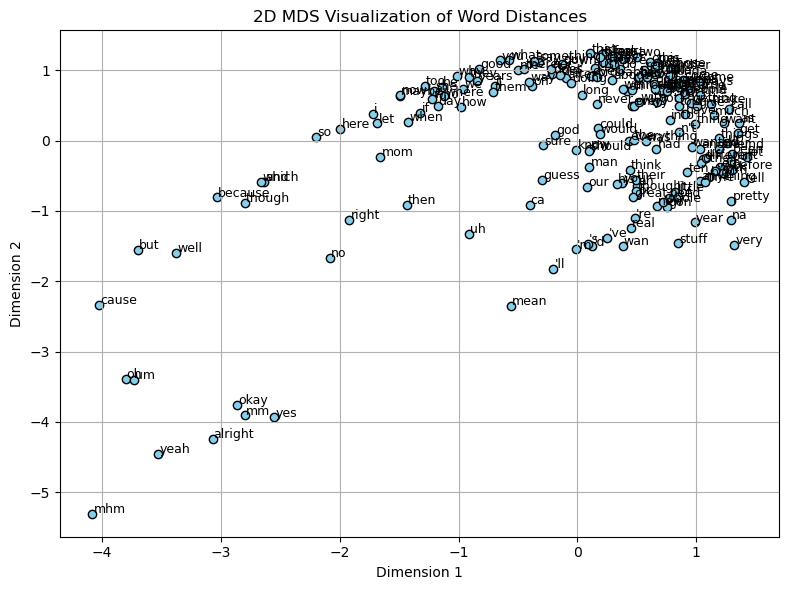

In [29]:
plt.figure(figsize=(8, 6))
plt.scatter(mds_coords[:, 0], mds_coords[:, 1], color='skyblue', edgecolors='k')


for i, label in enumerate(labels):
    plt.text(mds_coords[i, 0] + 0.01, mds_coords[i, 1] + 0.01, label, fontsize=9)

plt.title("2D MDS Visualization of Word Distances")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.show()

## Vertex in interval